<a href="https://colab.research.google.com/github/syafitriwijaya/PengalamanBelajar/blob/main/Machine%20Learning/Denteeth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import itertools
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optim
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from keras.preprocessing.image import ImageDataGenerator

In [2]:
module_selection = ("mobilenet_v2_100_224", 224)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/5".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5 with input size (224, 224)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "drive/MyDrive/denteeth/"
TRAIN_DIR = os.path.join(path, 'train')
TEST_DIR = os.path.join(path, 'test')
VAL_DIR = os.path.join(path, 'validation')

In [5]:
def explore_and_visualize_dataset(path, dataset_type="Train"):
    result_dict = dict()
    for folder in os.listdir(path):
        len_files = len(os.listdir(os.path.join(path, folder)))
        result_dict[folder] = len_files
    
    label = list(result_dict.keys())
    values_count = list(result_dict.values())
    print(f"Hasil Counting {dataset_type} Dataset")
    print("-"*70)
    plt.title(f"Visualisasi {dataset_type} Dataset")
    plt.bar(range(len(label)), values_count, tick_label=label)
    plt.show()
    for label, count in zip(label, values_count):
        print(f"{count} Gambar yang ditemukan di dalam folder {label}")
    print("-"*70)


In [6]:
train_val_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=35,
                                      zoom_range=[0.5, 1.1],
                                      width_shift_range= 0.25,
                                      height_shift_range = 0.25,
                                      shear_range=0.15,
                                      horizontal_flip=True,
                                      vertical_flip= True,
                                      fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_set = train_val_datagen.flow_from_directory(
            TRAIN_DIR,
            class_mode="categorical",
            batch_size= BATCH_SIZE,
            target_size=IMAGE_SIZE,
            seed =42
)

val_set = train_val_datagen.flow_from_directory(
            VAL_DIR,
            class_mode="categorical",
            batch_size= BATCH_SIZE,
            target_size=IMAGE_SIZE
)
test_set = test_datagen.flow_from_directory(
            TEST_DIR,
            class_mode="categorical",
            batch_size= 2* BATCH_SIZE,
            target_size=  IMAGE_SIZE
)

Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


In [8]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_set.num_classes, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build([None, 224, 224, 3])
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optim.RMSprop(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [10]:
steps_per_epoch = train_set.samples // train_set.batch_size
validation_steps = val_set.samples // val_set.batch_size

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', min_lr=1e-8) 
early_stop_cb = callbacks.EarlyStopping(patience=15,monitor='val_accuracy', restore_best_weights= True)
callbacks = [reduce_lr, early_stop_cb]
history = model.fit(train_set,
                    epochs=25, steps_per_epoch=steps_per_epoch,
                    validation_data=val_set,
                    callbacks=callbacks,
                    validation_steps=validation_steps).history

Epoch 1/25
1/1 [==============================] - 65s 65s/step - loss: 1.7235 - accuracy: 0.4688 - val_loss: 1.6106 - val_accuracy: 0.4062 - lr: 1.0000e-04
Epoch 2/25
1/1 [==============================] - 24s 24s/step - loss: 1.3480 - accuracy: 0.6250 - val_loss: 1.0211 - val_accuracy: 0.4688 - lr: 1.0000e-04
Epoch 3/25
1/1 [==============================] - 24s 24s/step - loss: 0.9646 - accuracy: 0.5000 - val_loss: 0.9057 - val_accuracy: 0.5312 - lr: 1.0000e-04
Epoch 4/25
1/1 [==============================] - 27s 27s/step - loss: 1.1836 - accuracy: 0.3438 - val_loss: 0.8580 - val_accuracy: 0.4688 - lr: 1.0000e-04
Epoch 5/25
1/1 [==============================] - 24s 24s/step - loss: 0.7898 - accuracy: 0.5000 - val_loss: 0.8759 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/25
1/1 [==============================] - 24s 24s/step - loss: 0.6776 - accuracy: 0.6250 - val_loss: 1.0482 - val_accuracy: 0.4375 - lr: 1.0000e-04
Epoch 7/25
1/1 [==============================] - 24s 24s/step -

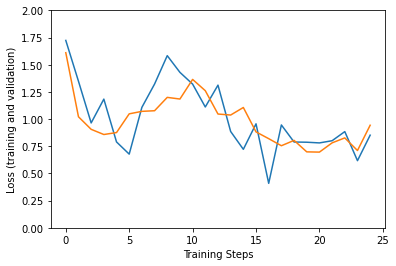

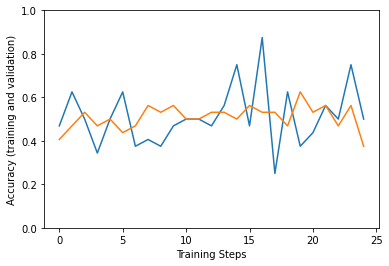

In [11]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(history["loss"])
plt.plot(history["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])

In [12]:
def evaluate_model(model, test_set):
    X, y = test_set.next()
    classes_ind = test_set.class_indices
    labels = list(classes_ind.keys())
    print('Loss of the model is - ', model.evaluate(X, y)[0])
    print('Accuracy of the model is - ', model.evaluate(X, y)[1]*100, '%')
    predict = model.predict(X)
    predict = np.argmax(predict, axis=1)
    predict = predict.reshape(1, -1)[0]
    y_label = np.argmax(y, axis=1)
    print(classification_report(y_label, predict, target_names =labels))

    conf_matrix = confusion_matrix(y_label, predict)
    ConfusionMatrixDisplay(conf_matrix, display_labels=np.array(labels))
    plt.show()

In [13]:
evaluate_model(model, test_set)

2/2 [==============================] - 4s 1s/step - loss: 0.6792 - accuracy: 0.6406
Loss of the model is -  0.6791657209396362
2/2 [==============================] - 2s 863ms/step - loss: 0.6792 - accuracy: 0.6406
Accuracy of the model is -  64.0625 %
                 precision    recall  f1-score   support

  healthy teeth       0.86      0.63      0.73        49
unhealthy teeth       0.36      0.67      0.47        15

       accuracy                           0.64        64
      macro avg       0.61      0.65      0.60        64
   weighted avg       0.74      0.64      0.67        64



In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpdktu495b/assets


INFO:tensorflow:Assets written to: /tmp/tmpdktu495b/assets
